In [3]:
#DO ALL PROCESS AT ONE TIME
from imp import reload 
import sys
from allProcess import *
reload(sys.modules['allProcess'])
from allProcess import *

IMG_LIST = ['facebook1']
#IMG_LIST = list(range(6307,6316))
#((w1+h1>f*7) and (w2+h2>f*7))
for i in IMG_LIST:
    print('===========PROCESSING IMAGE NUMBER '+str(i)+'=============')
    allProcess(str(i))

In [6]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt


IMAGE_NUMBER = str('6310')
#IMAGE_NUMBER = 'facebook'
# img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
# h,w,_ = img.shape
# img = cv2.resize(img, (int(w*0.5),int(h*0.5)))
# cv2.imwrite('iosScreenshot/IMG_'+IMAGE_NUMBER+'1.png', img)
# plt.figure(figsize=(50,25))
# plt.imshow(img)

image size:  2436 * 1125
lowThreshold, highThreshold, mean: 16 33 165.34134209085934
canny mean: 3.8473782156540777
canny mean after dilate by 7 : 35.814263820470714
number of contour result: 98
number of contours after filted by hierarchy: 51
number of contours after filted by size: 50
number of contours after filted out img noises: 47


<Figure size 3600x1800 with 0 Axes>

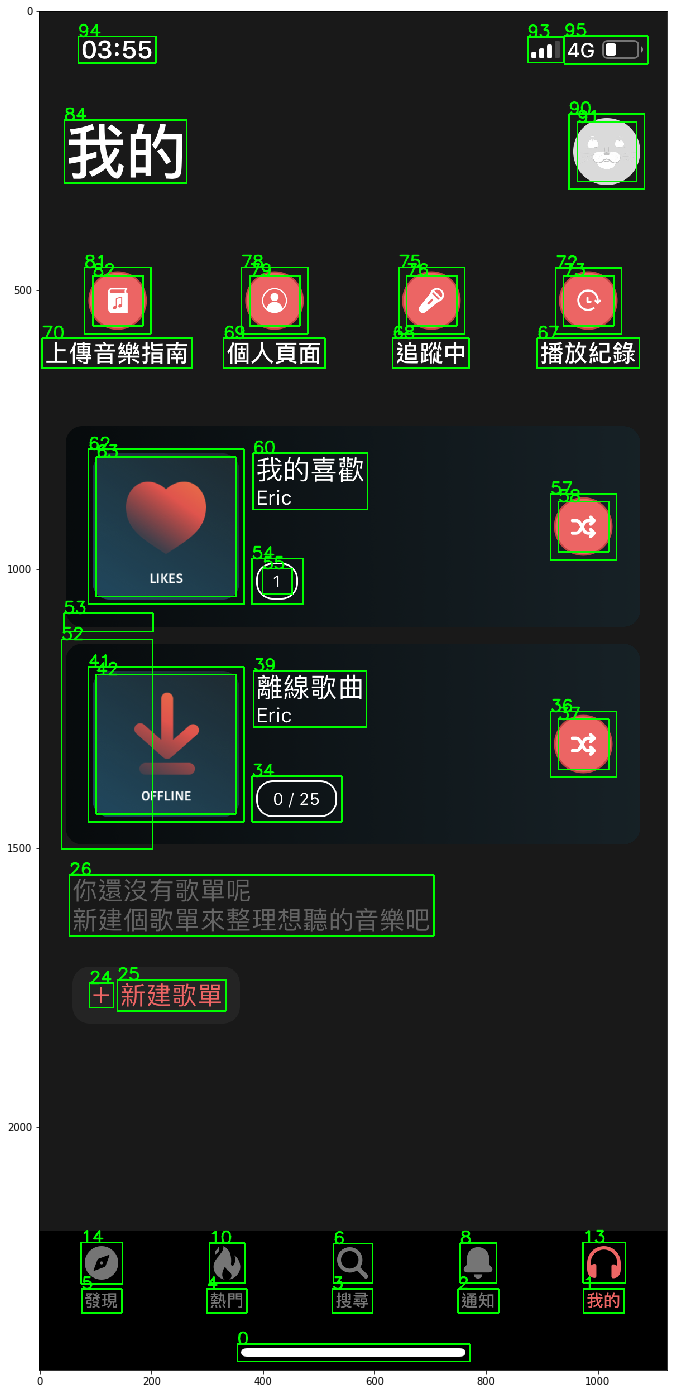

In [29]:
from getContourInfo import *
reload(sys.modules['getContourInfo'])
from getContourInfo import *

img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
height,width,_ = img.shape

print('image size: ', height, '*', width)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lowThreshold, highThreshold, mean = updateLowHighThreshold(gray)
print("lowThreshold, highThreshold, mean:",lowThreshold, highThreshold, mean)

blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
gray_edges = cv2.Canny(blur_gray, lowThreshold, highThreshold)

mean_canny = np.average(gray_edges)
print('canny mean:',mean_canny)

if mean_canny<=7:
    i=7
elif 7<mean_canny<17:
    i=5
else:
    i=3

gray_edges = addDilate(gray_edges, i)
#加深edge
mean_canny = np.average(gray_edges)

print('canny mean after dilate by '+str(i)+' :',mean_canny)

cv2.imwrite('result/canny.jpg', gray_edges)

result, hierarchy, contourInfo = getContourInfo(gray_edges)

contourInfo = removeImgNoise(contourInfo, gray)
print('number of contours after filted out img noises:', len(contourInfo))

clone = img.copy()
for c in result:
    (x, y, w, h) = cv2.boundingRect(c)
    #if w>=30 and h>=30: 
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #長方形框出contour

cv2.imwrite('result/'+IMAGE_NUMBER+'.png', clone)
plt.figure(figsize=(50,25))
clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
#matplotlib needs to change to rgb
#plt.imshow(clone)

#利用hierarchy 資訊篩選重要的contours
#print(result)
#print(len(hierarchy[0]))
#print(hierarchy[0])
#同層下一個輪廓的序號、同層上一個輪廓的序號、子輪廓的序號、父輪廓的序號。
#contourInfo: [[輪廓編號, 輪廓hier資訊],[輪廓座標]]
clone2 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone2, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

cv2.imwrite('result/better_'+IMAGE_NUMBER+'.png', clone2)
plt.figure(figsize=(50,25))
clone2 = cv2.cvtColor(clone2, cv2.COLOR_BGR2RGB)
plt.imshow(clone2)

filt = [n for n in contourInfo if n[0][1][3]!=-1]
#篩選條件用
#print(filt)


In [28]:
%%time
##辨識截圖上的文字並且加入contourInfo
## concurrent.futures version
from addText import *
reload(sys.modules['addText'])
from addText import *

import tesserocr
import pytesseract

from PIL import Image
import concurrent.futures
import queue

import time
import os

NUM_THREADS = os.cpu_count()
NUM_THREADS = 8
print('Logical Processors: ',NUM_THREADS)
#tesserocr_queue = queue.Queue()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.fastNlMeansDenoising(img_gray)
#denoising


for t_num in range(NUM_THREADS):
    tesserocr_queue.put([t_num, tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)])

start = time.time()

#from itertools import repeat
with concurrent.futures.ThreadPoolExecutor(NUM_THREADS) as executor:
    futures = {executor.submit(addText, c, img_gray): c for c in contourInfo}
    concurrent.futures.wait(futures)
#     futures = executor.map(addText, contourInfo, repeat(img_gray))
#     concurrent.futures.wait(futures)
    
    
end = time.time()
print('took tot: ' + str(end - start))
for _ in range(NUM_THREADS):
    t_num, api = tesserocr_queue.get(block=True)
    api.End()
    
    
clone3 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone3, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        

plt.figure(figsize=(50,25))
clone3 = cv2.cvtColor(clone3, cv2.COLOR_BGR2RGB)
plt.imshow(clone3)

##tesserocr: 
# img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
# pil_crop = Image.fromarray(img_crop)
# api.SetImage(pil_crop)
# ocrResult = api.GetUTF8Text()
# conf = api.MeanTextConf()

##pytesseract:
# ocr = pytesseract.image_to_data(img_crop,lang='eng+chi_tra',config='--psm 6', output_type='data.frame')
# text = ocr[ocr.conf != -1]
# lines = text.groupby('block_num')['text'].apply(list)[1]
# conf = text.groupby(['block_num'])['conf'].mean()[1]
# ocrResult = ''.join(lines)




Logical Processors:  8


KeyboardInterrupt: 

0 [[0, [1, -1, -1, -1]], [355, 2389, 416, 30], ['De', 14]]
1 [[1, [2, 0, -1, -1]], [975, 2290, 72, 43], ['我的', 96]]
2 [[2, [3, 1, -1, -1]], [750, 2290, 72, 43], ['通知', 96]]
3 [[3, [4, 2, -1, -1]], [300, 2290, 72, 43], ['熱門', 95]]
4 [[4, [5, 3, -1, -1]], [75, 2290, 73, 43], ['發現', 93]]
5 [[5, [6, 4, -1, -1]], [525, 2289, 72, 44], ['搜尋', 95]]
6 [[6, [8, 5, 7, -1]], [527, 2209, 70, 70], ['Q', 92]]
7 [[8, [10, 6, 9, -1]], [754, 2208, 65, 71], ['', 0]]
8 [[10, [11, 8, -1, -1]], [974, 2207, 75, 72], ['Y', 26]]
9 [[11, [14, 10, 12, -1]], [305, 2207, 63, 74], ['®', 35]]
10 [[14, [23, 11, 15, -1]], [75, 2207, 74, 74], ['0', 78]]
11 [[24, [25, 23, -1, -1]], [90, 1742, 43, 44], ['+', 96]]
12 [[25, [26, 24, -1, -1]], [141, 1736, 193, 56], ['新建歌單', 91]]
13 [[26, [33, 25, 27, -1]], [54, 1547, 652, 110], ['你還沒有歌單呢 新建個歌單來整理想聽的音樂吧', 91]]
14 [[33, [35, 26, 34, -1]], [381, 1371, 161, 82], ['(0/25)', 78]]
15 [[35, [38, 33, 36, -1]], [916, 1255, 118, 118], ['@', 45]]
16 [[36, [-1, -1, 37, 35]], [930, 1269,

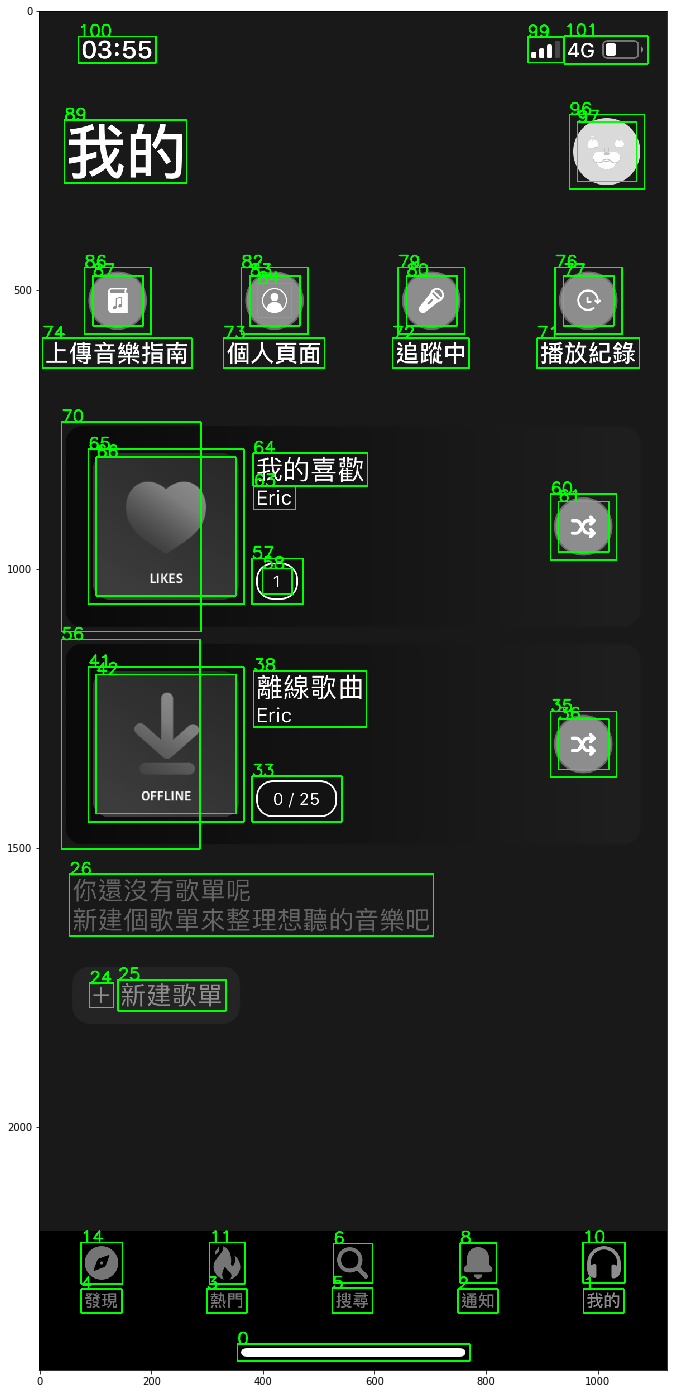

In [9]:
# import threading
# import multiprocessing as mp

# tesserocr.get_languages()
for i, c in enumerate(contourInfo):
    print(i, c)
# print(len(contourInfo))


# import concurrent.futures



# def say_hello_to(name):
#     print(name)
#     return f'Hi, {name}'


# names = ['John', 'Ben', 'Bill', 'Alex', 'Jenny'] * 10


# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     results = {executor.submit(say_hello_to, name): name for name in names}
#     concurrent.futures.wait(results)
print(img.shape)
plt.figure(figsize=(50,25))
sss = cv2.cvtColor(img_gray.copy(), cv2.COLOR_BGR2RGB)
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(sss, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(sss, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(sss)

dilate
monty 66 [66]


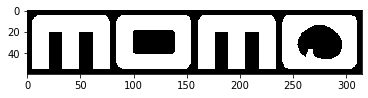

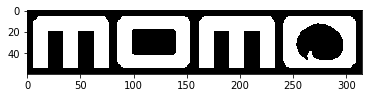

In [12]:
##ocr test for one contour
api = tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)
img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gray = cv2.fastNlMeansDenoising(img_gray)
x,y,w,h = contourInfo[64][1]
# # x = int(x+0.02*w)
# # y = int(y+0.05*h)
# # w = int(0.96*w)
# # h = int(0.9*h)
flag=0
for j in range(1):
    ratio = [h/(h+w), w/(h+w)]
    s = 0.1*j*w if w>h else 0.1*j*h
    ratio = [int(s*k) for k in ratio]
    ##要設定s還是固定距離就好？？
    y_low = y-ratio[0] if y-ratio[0]>=0 else 0
    y_upp = y+h+ratio[0] if y+h+ratio[0]<img_gray.shape[0] else img_gray.shape[0]
    x_low = x-ratio[1] if x-ratio[1]>=0 else 0
    x_upp = x+w+ratio[1] if x+w+ratio[1]<img_gray.shape[1] else img_gray.shape[1]
    #img_crop = img_gray[y-ratio[0]:y+h+ratio[0], x-ratio[1]:x+w+ratio[1]].copy()
    img_crop = img_gray[y_low:y_upp, x_low:x_upp].copy()
    hc,wc = img_crop.shape
    if j==0: mean_crop = np.average(img_crop)
    if mean_crop <= 140:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ##binarize

    if y_low!=0: 
        img_crop[0:ratio[0],:] = 255
        img_crop[ratio[0]+h:hc,:] = 255
    else: 
        img_crop[0:y,:] = 255
        img_crop[y+h:hc,:] = 255

    if x_low!=0: 
        img_crop[:,0:ratio[1]] = 255
        img_crop[:,ratio[1]+w:wc] = 255
    else: 
        img_crop[:,0:x] = 255
        img_crop[:,x+w:wc] = 255
    ##等比例拉遠並把外圍pixel設為255

    #img_crop = cv2.resize(img_crop, (int(wc*10),int(hc*10)))
    #圖片放大
    img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
    pil = Image.fromarray(img_crop)
    api.SetImage(pil)
    ocrResult = api.GetUTF8Text()
    conf = api.MeanTextConf()
    
    ##直接切割圖片後各自辨識
    


    if conf==0: flag+=1 
    else: flag=0
    if conf<=70:
        kernel = np.ones((3,3), np.uint8)
        img_crop_ero = cv2.erode(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_ero)
        api.SetImage(pil)
        ocrResult1 = api.GetUTF8Text()
        conf1 = api.MeanTextConf()
        


        img_crop_dil = cv2.dilate(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_dil)
        api.SetImage(pil)
        ocrResult2 = api.GetUTF8Text()
        conf2 = api.MeanTextConf()
        


        if conf1>=conf2:
            ocrResult = ocrResult1
            conf = conf1
            print('erode')
            plt.figure()
            plt.imshow(img_crop_ero)
        else:
            ocrResult = ocrResult2
            conf = conf2
            print('dilate')
            plt.figure()
            plt.imshow(img_crop_dil)
            ##辨識不出來就加粗字體or變細

        if conf==0: flag+=1 
        else: flag=0
    ocrResult = ocrResult.strip().replace(" ","").replace("\n"," ")   
    print(ocrResult,conf, api.AllWordConfidences())
    plt.figure()
    plt.imshow(img_crop)

    if conf>=95 or (conf>=80 and j>=3) or (conf>=70 and j>=10) or flag==4: pass

# plt.imshow(img_crop)






before combine:  49
after combine1:  24
after combine2:  24
after combine3:  24
[[99, [100, 96, -1, -1]], [875, 44, 215, 50], ['4G國,', 75]]
[[100, [101, 99, -1, -1]], [70, 45, 139, 48], ['03:55', 93]]
[[96, [99, 89, 97, -1]], [950, 185, 134, 134], ['@', 54]]
[[89, [96, 86, 90, -1]], [45, 195, 219, 113], ['我的', 96]]
[[74, [76, 73, 75, -1]], [6, 459, 267, 181], ['回', 94]]
[[73, [74, 72, -1, -1]], [330, 459, 181, 181], ['個人頁面', 93]]
[[72, [73, 71, -1, -1]], [633, 459, 137, 181], ['追蹤中', 93]]
[[71, [72, 70, -1, -1]], [892, 459, 183, 181], ['播放紀錄', 96]]
[[65, [70, 64, 66, -1]], [40, 736, 327, 376], ['LIKES', 96]]
[[64, [65, 63, -1, -1]], [383, 792, 205, 59], ['我的喜歡', 96]]
[[63, [64, 60, -1, -1]], [384, 851, 75, 42], ['Eric', 96]]
[[60, [63, 57, 61, -1]], [916, 865, 118, 118], ['2G', 57]]
[[57, [60, 56, 58, -1]], [381, 981, 91, 82], ['1', 96]]
[[41, [56, 38, 42, -1]], [40, 1126, 327, 376], ['~™ OFFLINE', 85]]
[[38, [41, 35, 39, -1]], [384, 1182, 202, 101], ['離線歌曲 Eric', 93]]
[[35, [38, 33, 3

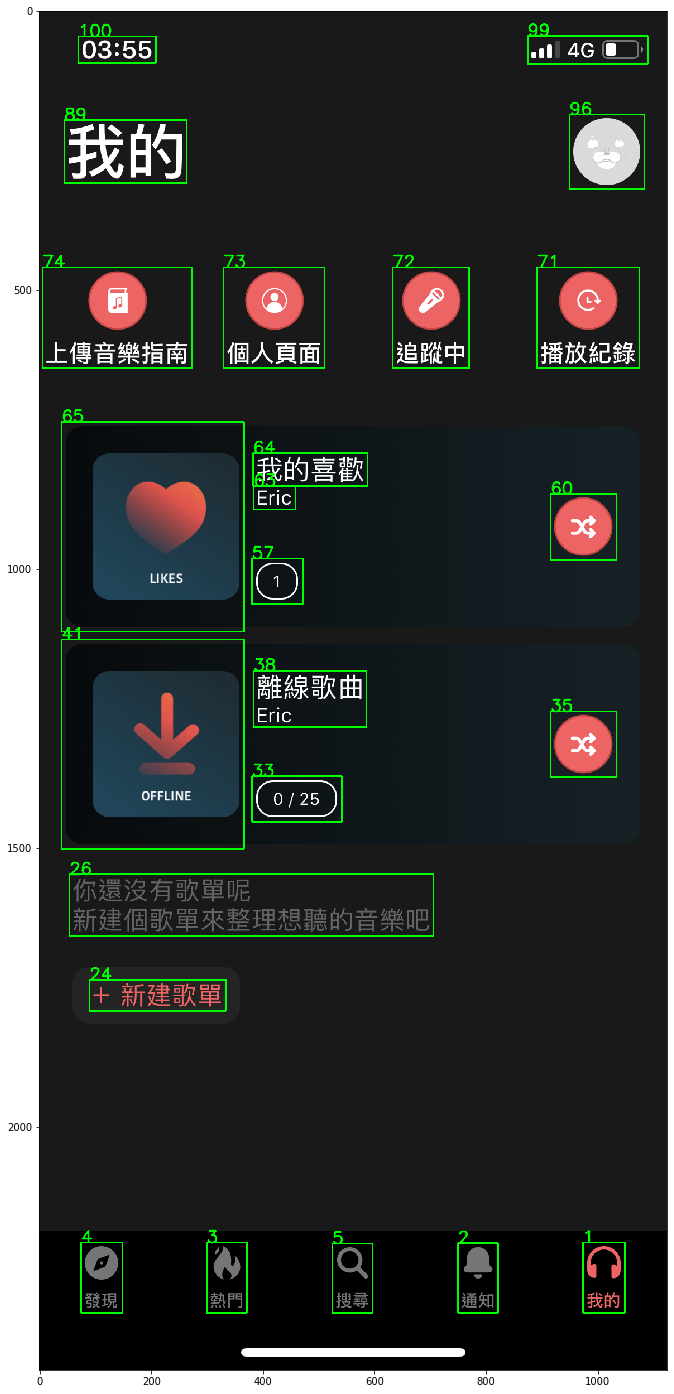

In [10]:
##c,d distance limitation
#d in c: upper left and (center or y_axis dist)
#c in d: upper left and (center or y_axis dist)
#d on right of c: (d's upper left - c's upper right) or (d's bottom left - c's bottom right) and (center or y_axis dist)
#d on left of c: (d's upper right - c's upper left) or (d's bottom right - c's bottom left)and (center or y_axis dist)
#d at top:(d's bottom left - c's upper left) or (d's bottom right - c's upper right) and center
#d at bottom:(d's upper left - c's bottom left) or (d's upper right - c's bottom right) and center

##combine contours that might be in the same element
#print(contourInfo)
#[[輪廓編號, 輪廓hier資訊],[x,y,w,h],[輪廓文字,confidence]]
import math 
from combineContour import *
reload(sys.modules['combineContour'])
from combineContour import *

sizeOG = img.shape
h,w,_ = img.shape
dist_factor = (w*0.01,h*0.01) if w<h else (h*0.01,w*0.01)
contourInfo_new = contourInfo.copy()
contourInfo_new.reverse()

        

contourInfo_new = combineContour(contourInfo_new, sizeOG)

print('before combine: ', len(contourInfo))
print('after combine1: ', len(contourInfo_new))
contourInfo_new = combineContour(contourInfo_new, sizeOG)
print('after combine2: ', len(contourInfo_new))
contourInfo_new = combineContour(contourInfo_new, sizeOG)
print('after combine3: ', len(contourInfo_new))



clone4 = img.copy()
for i,c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone4, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone4, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


cv2.imwrite('result/combined_'+IMAGE_NUMBER+'.jpg', clone4)
plt.figure(figsize=(50,25))
clone4 = cv2.cvtColor(clone4, cv2.COLOR_BGR2RGB)
plt.imshow(clone4)
for i in contourInfo_new:
    print(i)

In [11]:
f,l = dist_factor
print(f)
x1,y1,w1,h1= [834, 1004, 291, 270] #d
x2,y2,w2,h2 = [438, 1004, 687, 270] #c
x,y,w,h = [19, 1156, 834, 106]
mid_x1 = x1+(w1/2)
mid_y1 = y1+(h1/2)
mid_x2 = x2+(w2/2)
mid_y2 = y2+(h2/2)
center_dist = math.sqrt((mid_x1 - mid_x2)**2 + (mid_y1 - mid_y2)**2)
dtr_ctl = math.sqrt((x2 - (x1+w1))**2 + (y1 - y2)**2)
dbr_cbl = math.sqrt((x2 - (x1+w1))**2 + ((y1+h1) - (y2+h2))**2)
ctr_dtl = math.sqrt(((x2+w2) - x1)**2 + (y1 - y2)**2)
cbr_dbl = math.sqrt(((x2+w2) - x1)**2 + ((y1+h1) - (y2+h2))**2)

dbl_ctl = math.sqrt((x1 - x2)**2 + (y2 - (y1+h1))**2)
dbr_ctr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y2 - (y1+h1))**2)
cbl_dtl = math.sqrt((x1 - x2)**2 + (y1 - (y2+h2))**2)
cbr_dtr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y1 - (y2+h2))**2)

if x1>x2 and x1+w1>x2+w2 and (abs(mid_y1-mid_y2)<mid_x1-mid_x2):
    if (math.sqrt(((x2+w2) - x1)**2 + (y1 - y2)**2) <=f*4 or math.sqrt(((x2+w2) - x1)**2 + ((y1+h1) - (y2+h2))**2) <=f*4 or (x1 - (x2+w2))<=f*3.5 or x1<x2+w2) \
        and abs(mid_y1-mid_y2)<=f*5 and ((h1<f*25) or (h2<f*25)) and not((h1<f*12 and abs(h1-h2)<=0.5*f) or (abs(h1/w1 - h2/w2)<=0.05 and abs(h1+w1-(h2+w2))<=5*f and (x1 - (x2+w2))>=f*0.5)) and (abs(h1-h2)<=f*20):
        print('eee')

f*23
print(192/56, 517/249)
print(245,f*25)
w2+h2 <=f*23
print(w2+h2,f*23,w1-w2)
(math.sqrt((x1 - x2)**2 + (y1 - (y2+h2))**2) <=f*4)
#math.sqrt(((x1+w1) - (x2+w2))**2 + (y1 - (y2+h2)))**2 <=f*5
#(y1 - (y2+h2))<=f*3.5
f*30
abs(h1/w1 - h2/w2)<=0.2 and abs(h1+w1-(h2+w2))<=5*f
print(abs(mid_y1-mid_y2),mid_x1-mid_x2)
print((y1 - (y2+h2)),f*3.1)

print(abs(h1+w1-(h2+w2)),5*f)
print(h1/w1,h2/w2)
((h1<f*15) or (h2<f*15))
print(h1,h2,f*25)
not((h1<f*12 and abs(h1-h2)<=0.5*f) or (abs(h1/w1 - h2/w2)<=0.05 and abs(h1+w1-(h2+w2))<=5*f and (x1 - (x2+w2))>=f*0.5))
(abs(h1-h2)<=0.5*f)



11.25
3.4285714285714284 2.076305220883534
245 281.25
957 258.75 -396
0.0 198.0
-270 34.875
396 56.25
0.9278350515463918 0.3930131004366812
270 270 281.25


True

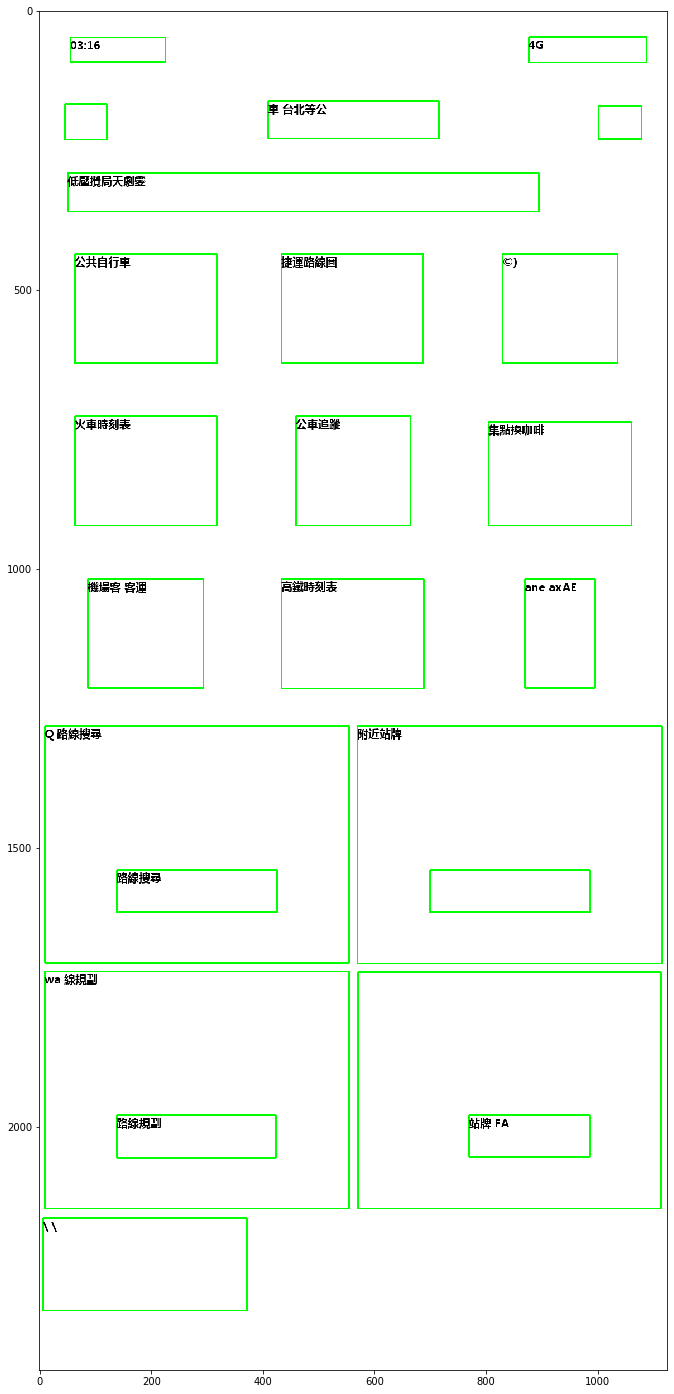

In [736]:
from PIL import Image, ImageDraw, ImageFont
clone5 = img.copy()
clone5[:][:][:] = 255
for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone5, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.putText(clone5, c[2][0], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

clone5 = cv2.cvtColor(clone5, cv2.COLOR_BGR2RGB)
pil5 = Image.fromarray(clone5)
for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    if c[2][1] >=70:
        draw = ImageDraw.Draw(pil5)
        fontText = ImageFont.truetype('msyhbd.ttf' , 20, encoding="utf-8")
        draw.text((x, y), c[2][0], (0, 0, 0), font=fontText)


pil5.save('result/contour&text_'+IMAGE_NUMBER+'.jpg')
plt.figure(figsize=(50,25))
plt.imshow(pil5)


24
99 [100, 96, -1, -1] [875, 44, 215, 50]
text:  ['4G國,', 75]
100 [101, 99, -1, -1] [70, 45, 139, 48]
text:  ['03:55', 93]
96 [99, 89, 97, -1] [950, 185, 134, 134]
89 [96, 86, 90, -1] [45, 195, 219, 113]
text:  ['我的', 96]
74 [76, 73, 75, -1] [6, 459, 267, 181]
text:  ['回', 94]
73 [74, 72, -1, -1] [330, 459, 181, 181]
text:  ['個人頁面', 93]
72 [73, 71, -1, -1] [633, 459, 137, 181]
text:  ['追蹤中', 93]
71 [72, 70, -1, -1] [892, 459, 183, 181]
text:  ['播放紀錄', 96]
65 [70, 64, 66, -1] [40, 736, 327, 376]
text:  ['LIKES', 96]
63 [64, 60, -1, -1] [384, 851, 75, 42]
text:  ['Eric', 96]
60 [63, 57, 61, -1] [916, 865, 118, 118]
64 [65, 63, -1, -1] [383, 792, 205, 59]
text:  ['我的喜歡', 96]
57 [60, 56, 58, -1] [381, 981, 91, 82]
text:  ['1', 96]
41 [56, 38, 42, -1] [40, 1126, 327, 376]
text:  ['~™ OFFLINE', 85]
35 [38, 33, 36, -1] [916, 1255, 118, 118]
38 [41, 35, 39, -1] [384, 1182, 202, 101]
text:  ['離線歌曲 Eric', 93]
33 [35, 26, 34, -1] [381, 1371, 161, 82]
text:  ['(0/25)', 78]
26 [33, 25, 27, -1] [54

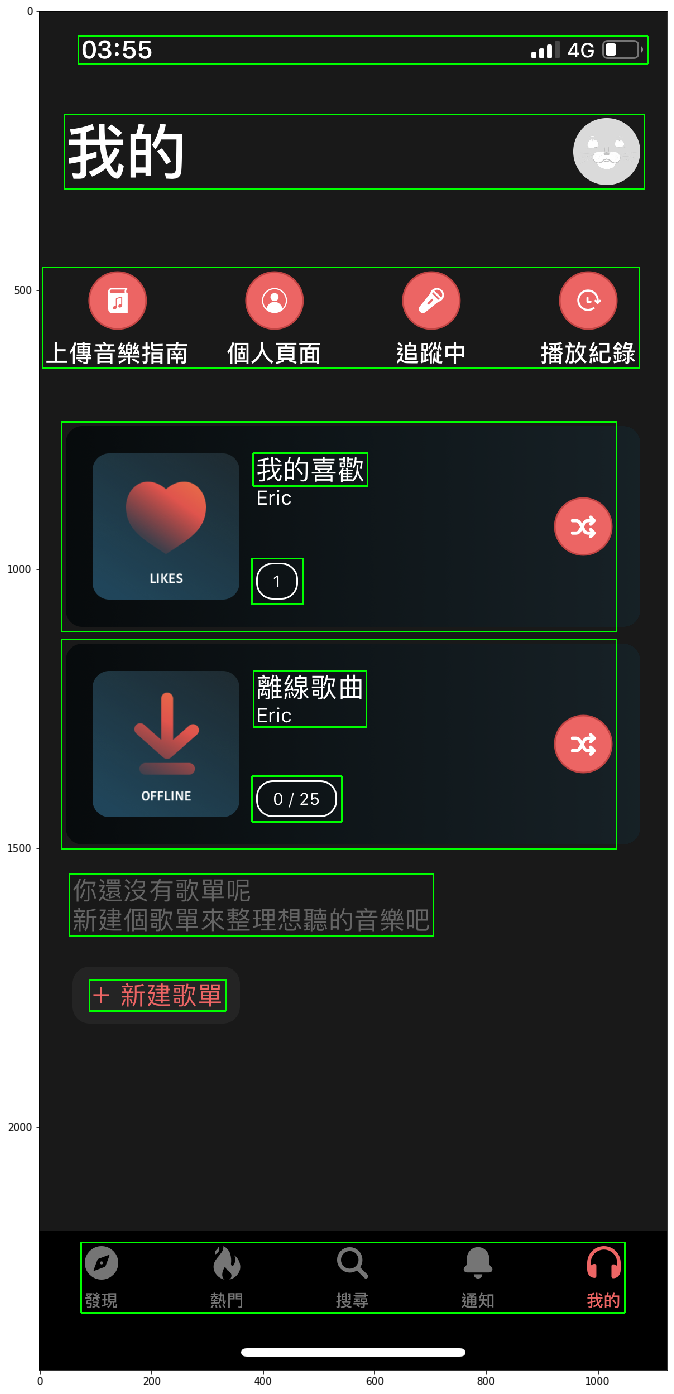

In [36]:
##產生截圖contour hierarchy的dict
import json
from generateDict import *
reload(sys.modules['generateDict'])
from generateDict import *


# with open('facebook.json', 'r') as fp:
#     j = json.load(fp)

# with open('facebook.json', 'w') as fp:
#     json.dump(j, fp, indent=4)

clone6 = img.copy()
mainDict, temp = generateJsonDict('test.json',img, contourInfo_new, sizeOG,clone6)
print('temp length: ', len(temp))

#clone6 = img.copy()
for i,c in enumerate(temp):
    x,y,w,h = c
    #cv2.rectangle(clone6, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.figure(figsize=(50,25))
clone6 = cv2.cvtColor(clone6, cv2.COLOR_BGR2RGB)
plt.imshow(clone6)

# generateXML('test.xml',img, contourInfo) 

shape: 2436 1125
2
i: div 1
j: div 2
k: img 3
k: button 4
k: button 5
j: ['ul', 'div'] 6
k: ['XCUIElementTypeActivityIndicator', 'div'] 7
k: div 8
l: div 9
m: button 10
m: div 11
n: div 12
n: button 13
n: div 14
n: button 15
n: div 16
n: button 17
l: div 18
l: div 19
k: div 20
l: div 21
l: div 22
l: div 23
m: div 24
m: ['ul', 'div'] 25
n: ['button', 'div'] 26
n: ['div', 'XCUIElementTypeImage', 'button'] 27
n: ['div', 'XCUIElementTypeImage', 'button'] 28
n: ['div', 'XCUIElementTypeImage', 'button'] 29
n: ['div', 'XCUIElementTypeImage', 'button'] 30
n: ['div', 'XCUIElementTypeImage', 'button'] 31
n: ['div', 'XCUIElementTypeImage', 'button'] 32
n: ['div', 'XCUIElementTypeImage', 'button'] 33
l: div 34
l: div 35
k: ['div', 'button'] 36
l: div 37
l: div 38
l: ['ul', 'div'] 39
m: ['div', 'button'] 40
n: ['XCUIElementTypeImage', 'div'] 41
n: div 42
n: XCUIElementTypeImage 43
n: div 44
m: ['div', 'button'] 45
n: ['XCUIElementTypeImage', 'div', 'div'] 46
n: div 47
n: ['XCUIElementTypeImage', 'd

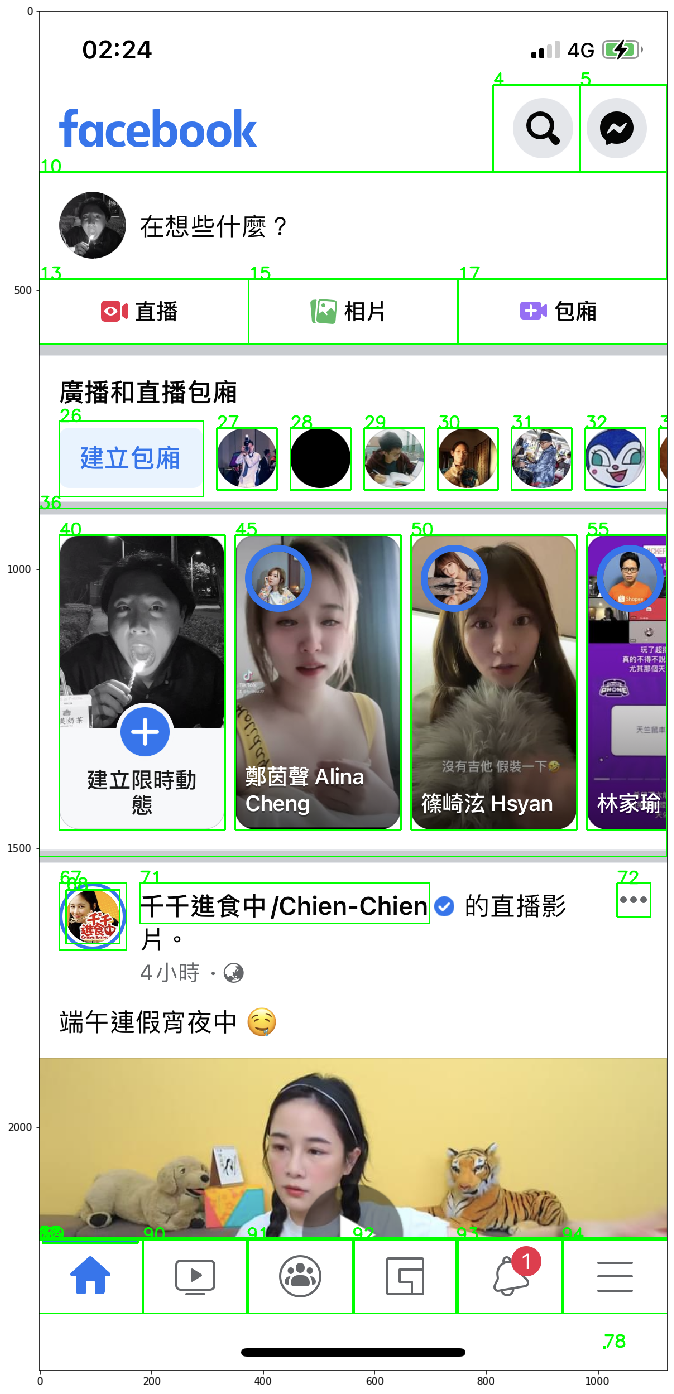

In [35]:
##analyze taad dumped dict
import json
with open('./experiment/facebook.json', 'r') as fp:
    j = json.load(fp)
img_test = cv2.imread('./experiment/facebook.png', 1)
height,width,_ = img_test.shape
print('shape:', height,width)
print(len(j['child']))
hierarchy_dict = j['child']



##94 elements
cnt = 0
for i in hierarchy_dict:
    cnt+=1
    print('i:',i["tag"], cnt)
    if i['tag'] == 'button' or ('button' in i['tag']):
        x = int(i['x'])
        y = int(i['y'])
        w = int(i['width'])
        h = int(i['height'])
        cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    for j in i['child']:
        cnt+=1
        print('j:',j["tag"], cnt)
        if j['tag'] == 'button' or ('button' in j['tag']):
            x = int(j['x'])
            y = int(j['y'])
            w = int(j['width'])
            h = int(j['height'])
            cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        for k in j['child']:
            cnt+=1
            print('k:',k["tag"], cnt)
            if k['tag'] == 'button' or ('button' in k['tag']):
                x = int(k['x'])
                y = int(k['y'])
                w = int(k['width'])
                h = int(k['height'])
                cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            for l in k['child']:
                cnt+=1
                print('l:',l["tag"], cnt)
                if l['tag'] == 'button' or ('button' in l['tag']):
                    x = int(l['x'])
                    y = int(l['y'])
                    w = int(l['width'])
                    h = int(l['height'])
                    cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                for m in l['child']:
                    cnt+=1
                    print('m:',m["tag"], cnt)
                    if m['tag'] == 'button' or ('button' in m['tag']):
                        x = int(m['x'])
                        y = int(m['y'])
                        w = int(m['width'])
                        h = int(m['height'])
                        cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    for n in m['child']:
                        cnt+=1
                        print('n:',n["tag"], cnt)
                        if n['tag'] == 'button' or ('button' in n['tag']):
                            x = int(n['x'])
                            y = int(n['y'])
                            w = int(n['width'])
                            h = int(n['height'])
                            cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                            cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                        for o in n['child']:
                            cnt+=1
                            print('o:',o["tag"], cnt)
                            if "_EA@text" in o: print('o text:',o["_EA@text"], cnt)
                            if o['tag'] == 'button' or ('button' in o['tag']):
                                x = int(o['x'])
                                y = int(o['y'])
                                w = int(o['width'])
                                h = int(o['height'])
                                cv2.rectangle(img_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                                cv2.putText(img_test, str(cnt), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

                            

#print(cnt)
plt.figure(figsize=(50,25))
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

number of contour result: 144
number of contours after filted by hierarchy: 48
number of contours after filted by size: 47
number of contours after filted out img noises: 44
Add Text Info
ggininder
number of contours after combination:  28
Write to dict
The all vision Dict!
********
CPU times: user 17.5 s, sys: 382 ms, total: 17.9 s
Wall time: 9.64 s


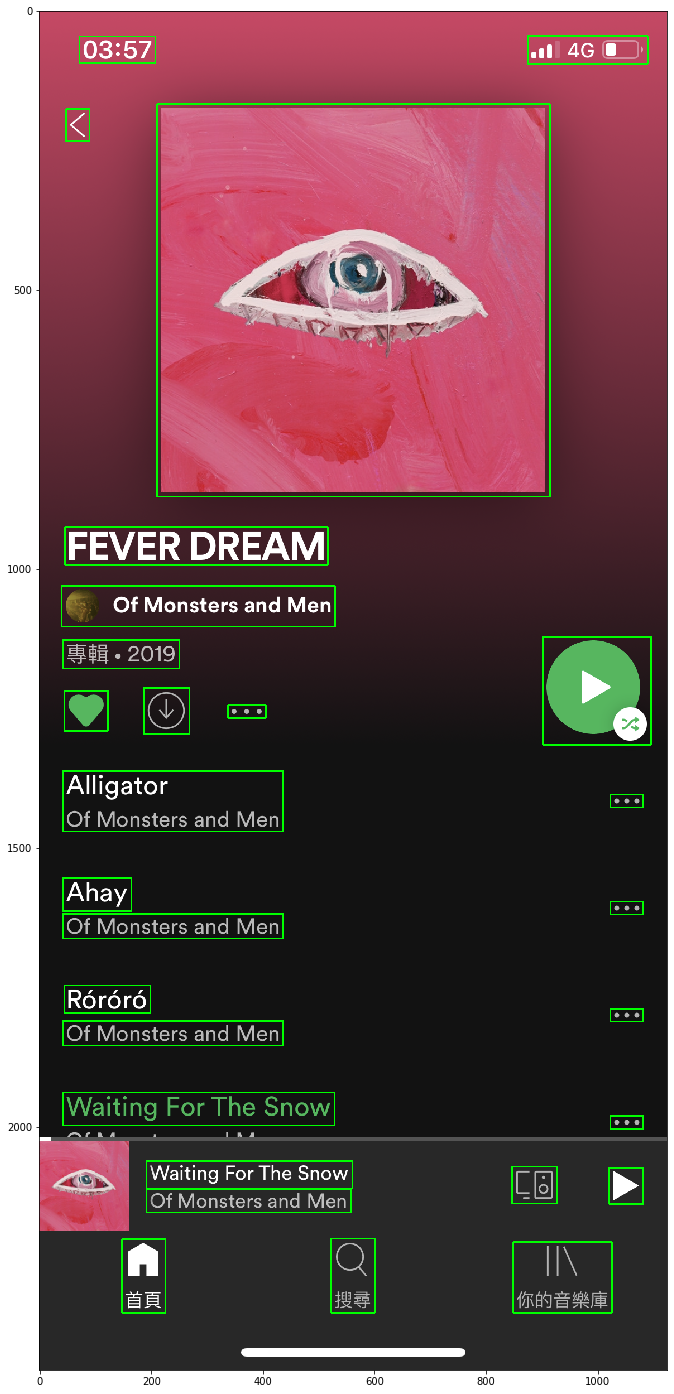

In [753]:
%%time
##class test
import cv2
from  matplotlib import pyplot as plt
from screenImageAnalyzer_test import screenImageAnalyzer
reload(sys.modules['screenImageAnalyzer_test'])
from screenImageAnalyzer_test import screenImageAnalyzer

img = cv2.imread('iosScreenshot/IMG_6318.png', 1)
cl = screenImageAnalyzer()
img = cl.getImage(img)
conDict, canvas, contours = cl.getVisionDict()

plt.figure(figsize=(50,25))
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.imshow(canvas)

In [744]:
import json
print(json.dumps(conDict, indent=4))
print(conDict)
for i,c in enumerate(contours):
    x,y,w,h = c[1]
    print(c)
    

{
    "_EA@isEnabled": true,
    "_EA@class": "XCUIElementTypeOther",
    "_EA@isHidden": false,
    "_EA@isClickable": false,
    "tag": "ol",
    "byVision": true,
    "positionX": 0,
    "positionY": 0,
    "width": 1125,
    "height": 2436,
    "child": [
        {
            "_EA@isEnabled": true,
            "_EA@class": "XCUIElementTypeOther",
            "_EA@isHidden": false,
            "_EA@isClickable": false,
            "tag": "div",
            "byVision": true,
            "positionX": 72,
            "positionY": 44,
            "width": 1018,
            "height": 50,
            "child": [
                {
                    "_EA@isEnabled": true,
                    "_EA@class": "XCUIElementTypeButton",
                    "_EA@isHidden": false,
                    "_EA@isClickable": true,
                    "tag": "button",
                    "positionX": 875,
                    "positionY": 44,
                    "width": 215,
                    "height": 

In [667]:
import copy
q = [1,2,3,4,5,6,7,[8]]
p = q.copy()
p = p.copy()

for c in p:
    if c==[8]:
        c.append(10)
        p.remove(c)
        

print(q)   
print(p)

for a,b in zip([1,2],[3,4]):
    print(a,b)

[1, 2, 3, 4, 5, 6, 7, [8, 10]]
[1, 2, 3, 4, 5, 6, 7]
1 3
2 4


In [482]:
unique, counts = np.unique(img_gray, return_counts=True)
print(max(counts),len(counts),len(unique))
unique

479401 256 256


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [683]:
a = [1,2,3,4,5]
# while len(a)>0:
#     c = a[0]
#     print('c',c)
#     for d in a[1:4]:
#         print('d',d)
#         a.remove(d)
#     a.remove(c)
    
for d in a:
    print(d)
    if d>2:
        a.remove(d)

s = [1,[2],3,[4],[4]]
s = set(tuple(s))
print(list(s))

1
2
3
5


TypeError: unhashable type: 'list'